In [1]:
from collections import defaultdict
import numpy as np
from itertools import combinations
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from matplotlib import pyplot as plt
import networkx as nx
import ndlib
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.utils import multi_runs
from bokeh.palettes import Category20_9 as cols
import future.utils
import warnings
warnings.simplefilter('ignore')

no display found. Using non-interactive Agg backend


In [2]:
def maxcut_hamiltonian_eigenvalue(G):
    # The Hamiltonian is H = sum(Pauli_Z(i) x Pauli_Z(j) - I)/2
    # The eigenvalue is the negation of the edges in cut solution
    # D-wave will minimize the energy of the Hamiltonian
    # The QUBO should be -xi-xj+2xixj
    # The corresponding Q matrix is as follows
    Q = defaultdict(int)
    for u, v in G.edges:
        #should be -1 & -2, but use -0.5 & 1 so we are not overcounting twice xi_xj and xj_x_i
        Q[(u,u)]+= -0.5 
        Q[(v,v)]+= -0.5
        Q[(u,v)]+= 1
    return Q
def solve(Q, chainstrength=8, numruns=100):
    # Run the QUBO on the solver from your config file
    sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
    response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
    energies = iter(response.data())

    return response.first
def brute_best(G):
    sub_lists = []
    for i in range(0, len(G.nodes())+1):
        temp = [list(x) for x in combinations(G.nodes(), i)]
        sub_lists.extend(temp)
    
    # Calculate the cut_size for all possible cuts
    cut_size = []
    for sub_list in sub_lists:
        cut_size.append(nx.algorithms.cuts.cut_size(G,sub_list))
    return max(cut_size)
def binary_split(G, sol, limit = 4, pos=None, infected_nodes = [], graph=False):
    if pos == None:
        pos = nx.spring_layout(G)
    if len(G.nodes) <= limit:
        return [G]
        
    labels = sol.sample
    colors = ['g' if i in infected_nodes else ('r' if labels[i] == -1 else 'b') for i in G.nodes]
    left = [i for i in G.nodes if labels[i] == -1]
    right = [i for i in G.nodes if labels[i] == 1]
    
    if graph:
        fig = plt.figure(constrained_layout=False)
        gs = fig.add_gridspec(nrows=2, ncols=3)
        gs.update(wspace=0, hspace=0)
        ax1 = fig.add_subplot(gs[:,:2])   
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax2 = fig.add_subplot(gs[0,2])  
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax3 = fig.add_subplot(gs[1,2]) 
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])
    
    left_G = G.subgraph(left)
    right_G = G.subgraph(right)
    left_colors = ['g' if i in infected_nodes else 'r'  for i in left_G.nodes]
    right_colors = ['g' if i in infected_nodes else 'b' for i in right_G.nodes]

    print("Dividing {} people into {} & {}".format(len(G.nodes), len(left_G.nodes), len(right_G.nodes)))
    if graph:
        nx.draw_networkx(G, node_size=600, alpha=.8, ax=ax1, pos=pos, node_color=colors)
        nx.draw_networkx(left_G, node_size=600, alpha=.8, ax=ax2, pos=pos, node_color=left_colors)
        nx.draw_networkx(right_G, node_size=600, alpha=.8, ax=ax3, pos=pos, node_color=right_colors)
    
    group = []
    
    
    Q = maxcut_hamiltonian_eigenvalue(left_G)
    sol = solve(Q)
    group.extend(binary_split(left_G, sol, pos=pos, infected_nodes=infected_nodes, limit=limit))
    
    Q = maxcut_hamiltonian_eigenvalue(right_G)
    sol = solve(Q)
    group.extend(binary_split(right_G, sol, pos=pos, infected_nodes=infected_nodes, limit=limit))
        
    return group
def sim_virus(G, r_infect=0.001, r_recover=0.01, infected_nodes = [], iteration=200):
    model = ep.SIRModel(G)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', r_infect) # infection rate
    cfg.add_model_parameter('gamma', r_recover) # recovery rate
    cfg.add_model_initial_configuration("Infected", infected_nodes)
    model.set_initial_status(cfg)
    iterations = model.iteration_bunch(iteration, node_status=False)
    trends = model.build_trends(iterations)     
    return model, trends, iterations
def sim_virus_group(groups, original_model, r_infect=0.001, r_recover=0.01, original_infected_nodes = [], iteration=200):
    net_trends = {'trends': {'node_count': {0:[0]*iteration, 1:[0]*iteration, 2:[0]*iteration}}}
    for g in groups:
        model, trends, iterations = sim_virus(g, r_infect, r_recover, [n for n in original_infected_nodes if n in g.nodes], iteration)
        for idx,i in enumerate(iterations):
            i_count = i['node_count']
            for jk, jv in i_count.items():
                net_trends['trends']['node_count'][jk][idx] += jv
    #print(net_trends)
    for i in range(1000):
        ctr = net_trends['trends']['node_count'][0][0]+net_trends['trends']['node_count'][1][0]+net_trends['trends']['node_count'][2][0]
        assert ctr == len(G.nodes), (ctr,i)
    return original_model, [net_trends]

Text(0.5, 1.0, 'You should not rave right now')

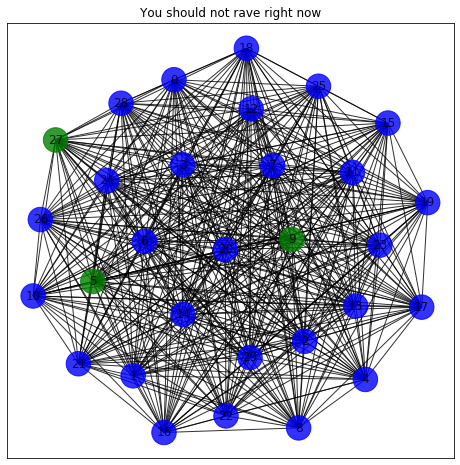

In [3]:
n = 30
init_infect = 0.1

G = nx.generators.classic.complete_graph(n)
pos = nx.spring_layout(G)
fig = plt.figure(figsize=(8,8))
default_axes = fig.add_subplot(frameon=True)

infected = np.random.choice(range(n),int(n*init_infect),replace=False)
colors = ['g' if i in infected else 'b' for i in G.nodes]
nx.draw_networkx(G, node_size=600, alpha=.8, ax=default_axes, pos=pos, node_color=colors)
default_axes.set_title("You should not rave right now")

# A toy example showing the split

In [5]:
Q = maxcut_hamiltonian_eigenvalue(G)
sol = solve(Q)
print("Approximate cut is:",-sol.energy)
groups = binary_split(G, sol, infected_nodes = infected, limit = 4)

Approximate cut is: 84.0
Dividing 30 people into 12 & 18
Dividing 12 people into 4 & 8
Dividing 8 people into 2 & 6
Dividing 6 people into 2 & 4
Dividing 18 people into 7 & 11
Dividing 7 people into 2 & 5
Dividing 5 people into 2 & 3
Dividing 11 people into 3 & 8
Dividing 8 people into 2 & 6
Dividing 6 people into 2 & 4


# Plot & Compare the Virus Effect

Dividing 30 people into 11 & 19
Dividing 11 people into 3 & 8
Dividing 8 people into 2 & 6
Dividing 6 people into 2 & 4
Dividing 19 people into 7 & 12
Dividing 7 people into 2 & 5
Dividing 5 people into 2 & 3
Dividing 12 people into 4 & 8
Dividing 8 people into 2 & 6
Dividing 6 people into 2 & 4
Dividing 30 people into 11 & 19
Dividing 11 people into 3 & 8
Dividing 19 people into 6 & 13
Dividing 13 people into 4 & 9
Dividing 9 people into 2 & 7
Dividing 30 people into 11 & 19
Dividing 19 people into 7 & 12


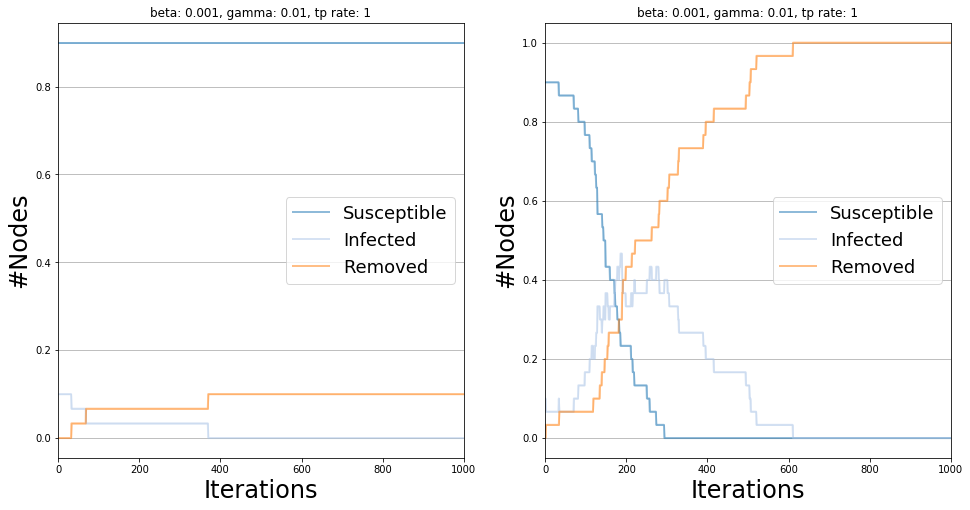

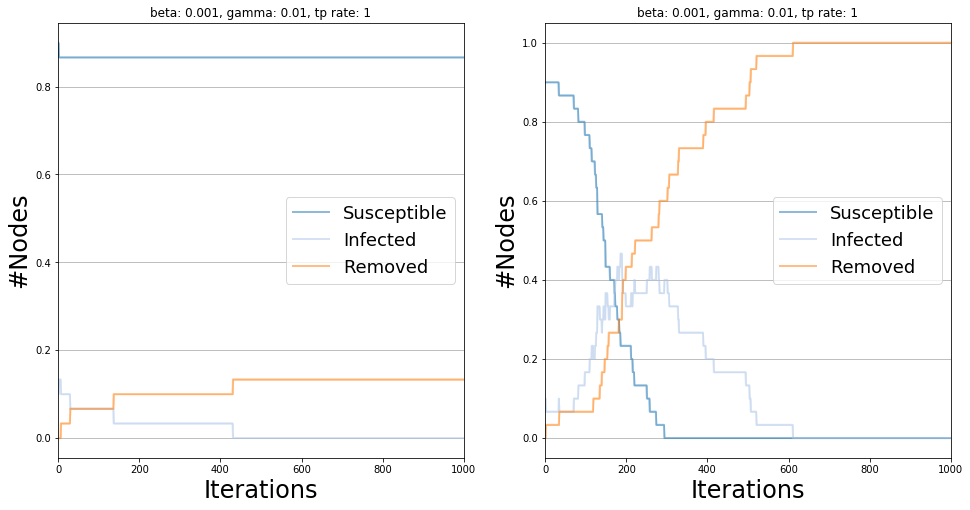

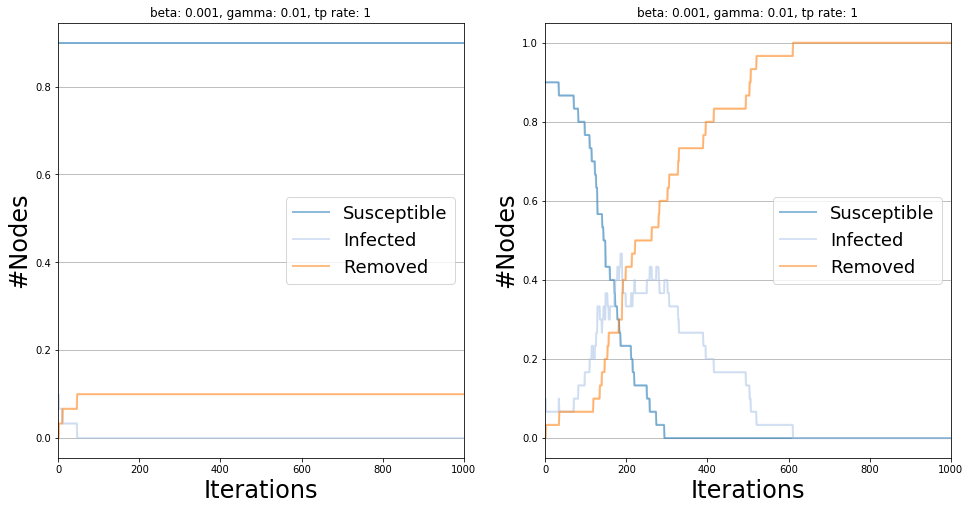

In [4]:
def plot(viz, ax):
    pres = viz.iteration_series(90)
    infos = viz.model.get_info()
    descr = ""

    for k, v in future.utils.iteritems(infos):
        descr += "%s: %s, " % (k, v)
    descr = descr[:-2].replace("_", " ")

    mx = 0
    i = 0
    for k, l in future.utils.iteritems(pres):
        mx = len(l[0])
        if viz.normalized:
            ax.plot(range(0, mx), l[1]/viz.nnodes, lw=2, label=viz.srev[k], alpha=0.5, color=cols[i])
            ax.fill_between(range(0,  mx), l[0]/viz.nnodes, l[2]/viz.nnodes, alpha="0.2",
                             color=cols[i])
        else:
            ax.plot(range(0, mx), l[1], lw=2, label=viz.srev[k], alpha=0.5, color=cols[i])
            ax.fill_between(range(0, mx), l[0], l[2], alpha="0.2",
                             color=cols[i])
        i += 1
    ax.grid(axis="y")
    ax.set_title(descr)
    ax.set_xlabel("Iterations", fontsize=24)
    ax.set_ylabel(viz.ylabel, fontsize=24)
    ax.legend(loc="best", fontsize=18)
    ax.set_xlim((0, mx))

    
original_model, original_trends, _ = sim_virus(G, infected_nodes = infected, iteration = 1000)
original_viz = DiffusionTrend(original_model, original_trends)
Q = maxcut_hamiltonian_eigenvalue(G)
sol = solve(Q)
for l in [4, 8, 16]:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    groups = binary_split(G, sol, infected_nodes = infected, limit = l)
    model, trends = sim_virus_group(groups, original_model, original_infected_nodes = infected, iteration = 1000)
    viz = DiffusionTrend(model, trends)
    plot(viz, ax[0])
    plot(original_viz, ax[1])

In [ ]:
#can you find more reaosnable graph?
#can you figure out the virus people? (more connections)-->splitting blindly may actually cause high infection because some groups are too small to digest the virus inside
#can you visualize the split better?